# MCMC analysis of cosmological FRB constraints using the Pade Approximants

**Note**: This notebook tests main functions and code

## Run properties and loading modules

In [1]:
### If the MCMC functions need to be imported from a file, this should be OFF
## Depends on how the OS handles multiprossecing
RUN_IN_NOTEBOOK = True

SAVE_DATA = False
SAVE_FIG = False

In [2]:
import sys
sys.path.append('../Python_scripts')
sys.path.append('./interpolation')

### Import packages
from config import *
from support import *
from cosmo_support import *
from mcmc_support import *

In [3]:
# ## Plotting
# plt.rcParams['font.family'] ='Times New Roman'
# plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [4]:
### MCMCM packages

if RUN_IN_NOTEBOOK:
    import emcee
    from multiprocessing import Pool
else:
    import mcmc_support_Svar
    mcmc_support_Svar.DATA_PATH = path
    mcmc_support_Svar.reload_with_path(path)
    from mcmc_support_Svar import *

## Generate data

In [5]:
## Number of random events
N_EVENTS = 20

## Draw random redshifts, based on given redshift
redshift_array = np.linspace(0.25, 2, 500)
z_centres = draw_redshift_distribution(redshift_array, H0=HUBBLE, Omega_m=OMEGA_MATTER, 
                                          N_draws=N_EVENTS)

In [6]:
DATA_PATH = './interpolation/095_C0mean.npz'
Sigmas, Errors, C0s, As, sigma_error_inter, C0_sigma_inter, A_sigma_inter = FRBs_load_and_create_interpolators(DATA_PATH)

In [7]:
# Theoretical DM, fiducial cosmo
DM_centres = dispersion_measure(z_centres, H0=HUBBLE, Om=OMEGA_MATTER, w=W_LAMBDA, alpha=f_ALPHA, f_IGM_0 = f_IGM)

In [8]:
## Simple Gaussian pdf - Scatter observations according to errors
DM_obs_centre_gauss = rng.normal(DM_centres, SIGMA_DM)

## Modelling the DM pdf -- Standard HOF
DM_obs_centre = np.zeros_like(z_centres)
s_DM_obs = np.zeros_like(z_centres)

for idx, z_val in enumerate(tqdm(z_centres)):
    DM_obs_centre[idx], s_DM_obs[idx], _ = \
        DM_diff_sampling(z=z_val, 
                        S=S_FRB, HOF=HOF,
                        sigma_error_inter=sigma_error_inter,
                        C0_sigma_inter=C0_sigma_inter,
                        A_sigma_inter=A_sigma_inter,
                        H0=HUBBLE, f_diff=f_IGM, f_diff_alpha=f_ALPHA,
                        Om=OMEGA_MATTER, w=W_LAMBDA, N_draws=1,
                        Error_factor = 1
                        )

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.36it/s]


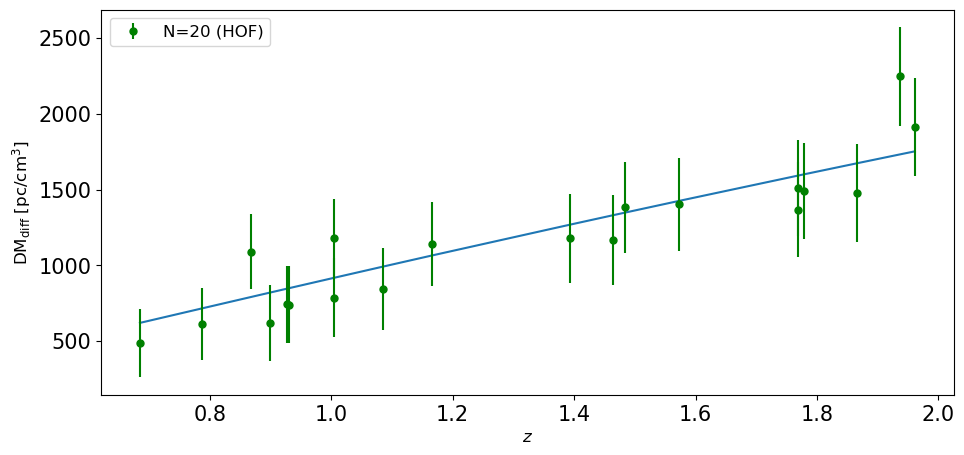

In [9]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(111)

ax1.plot(np.sort(z_centres), np.sort(DM_centres), c='tab:blue')
ax1.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=5, c='g', label=f'N={N_EVENTS} (HOF)')


ax1.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax1.set_xlabel(r'$z$', fontsize=12)
ax1.legend(loc='upper left', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [10]:
dm_range=np.linspace(0.25*DM_obs_centre[0], 500+2.0*DM_obs_centre[0], 2000)

error=1 * np.sqrt(f_variance_delta(S=S_FRB, z=z_centres[0], Om=OMEGA_MATTER, w=W_LAMBDA))

sigma_diff=sigma_error_inter(error)
C0=C0_sigma_inter(sigma_diff)
A=A_sigma_inter(sigma_diff)

p_range=[
    pdf_DM_cosmo(Delta=dm/DM_obs_centre[0], C_0=C0, A=A, sigma=sigma_diff, alpha=3, beta=3)/DM_obs_centre[0]
    for dm in dm_range]

In [11]:
p_obs = pdf_DM_cosmo(Delta=DM_centres[0]/DM_obs_centre[0], C_0=C0, A=A, sigma=sigma_diff, alpha=3, beta=3)/DM_obs_centre[0]

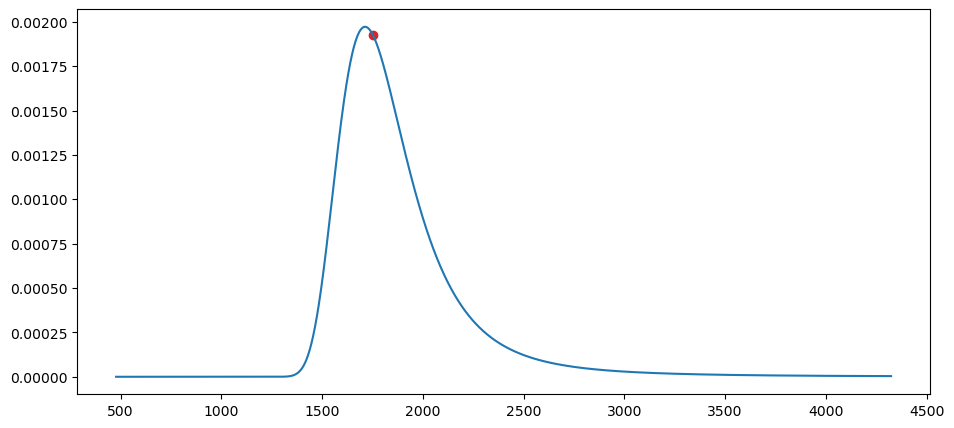

In [12]:
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(111)

ax1.plot(dm_range, p_range, c='tab:blue')
ax1.scatter(DM_centres[0], p_obs, c='tab:red')

plt.show()

---------------------------------------

In [13]:
for idx, z_v in enumerate(z_centres):
    LLHD_pdf = log_likelihood_frb_pdf([HUBBLE, OMEGA_MATTER, W_LAMBDA], z_v, DM_obs_centre[idx], s_DM_obs[idx], DATA_PATH)
    LLHD_gauss = log_likelihood_frb_gauss([HUBBLE, OMEGA_MATTER, W_LAMBDA], z_v, DM_obs_centre[idx], s_DM_obs[idx])

logLHD: -0.11987953099492209
logLHD: -0.15165195664257042
logLHD: -0.18805720344012264
logLHD: -0.0822358605775401
logLHD: -0.12207495922403222
logLHD: -0.17172733843448962
logLHD: -0.3232330040280802
logLHD: -0.49483903357431747
logLHD: -1.2593175639444034
logLHD: -0.08994493257808682
logLHD: -0.039318384410416206
logLHD: -0.04555718413943328
logLHD: -0.03424621352230907
logLHD: -0.25117558926858774
logLHD: -0.006612447698570557
logLHD: -0.15163798355085
logLHD: -0.0025549357357026194
logLHD: -0.7266674411123855
logLHD: -0.09348301602895721
logLHD: -0.0627691557134229


In [14]:
initial_params = np.array([74, 0.25, -1.5])
pos = initial_params + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

In [15]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_frb_pdf, args=(z_centres, DM_obs_centre, s_DM_obs, 40, 100, 0.0, 1.0, -2.0, 0.0, DATA_PATH)
)
sampler.run_mcmc(pos, 1000, progress=True);

C:\Users\klera\Documents\GitHub\DM_cosmic_Pade\Notebooks\../Python_scripts\mcmc_support.py:89: RuntimeWarning: divide by zero encountered in log10
  return np.sum(np.log10(p_obs))
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:24<00:00, 11.86it/s]


In [16]:
sampler_Pade = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_frb_Pade_pdf, args=(z_centres, DM_obs_centre, s_DM_obs, 40, 100, 0.0, 1.0, -2.0, 0.0, DATA_PATH)
)
sampler_Pade.run_mcmc(pos, 1000, progress=True);

C:\Users\klera\Documents\GitHub\DM_cosmic_Pade\Notebooks\../Python_scripts\mcmc_support.py:118: RuntimeWarning: invalid value encountered in log10
  log_prob = np.sum(np.log10(p_obs))
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.56it/s]


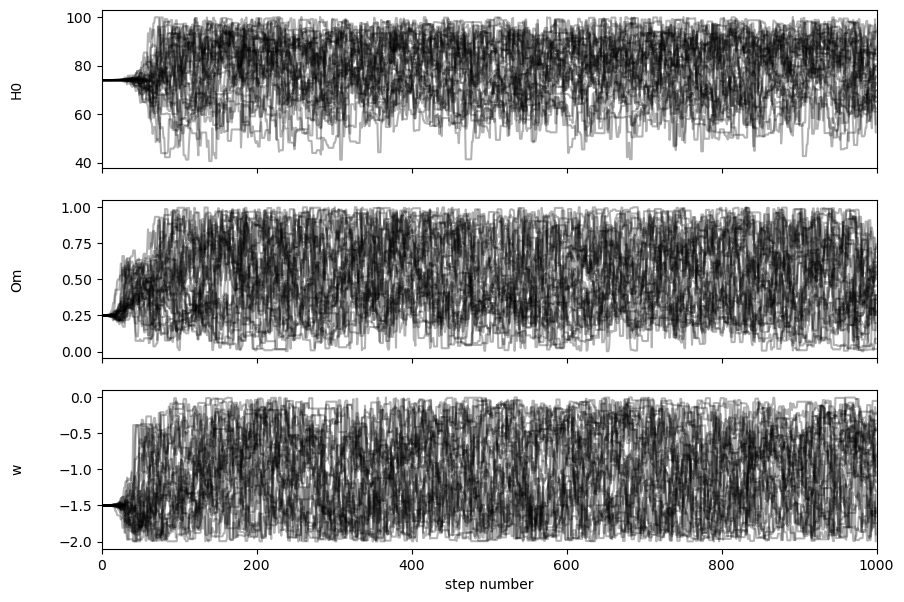

In [17]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["H0", "Om", "w"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [18]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
flat_samples_PD = sampler_Pade.get_chain(discard=100, thin=15, flat=True)

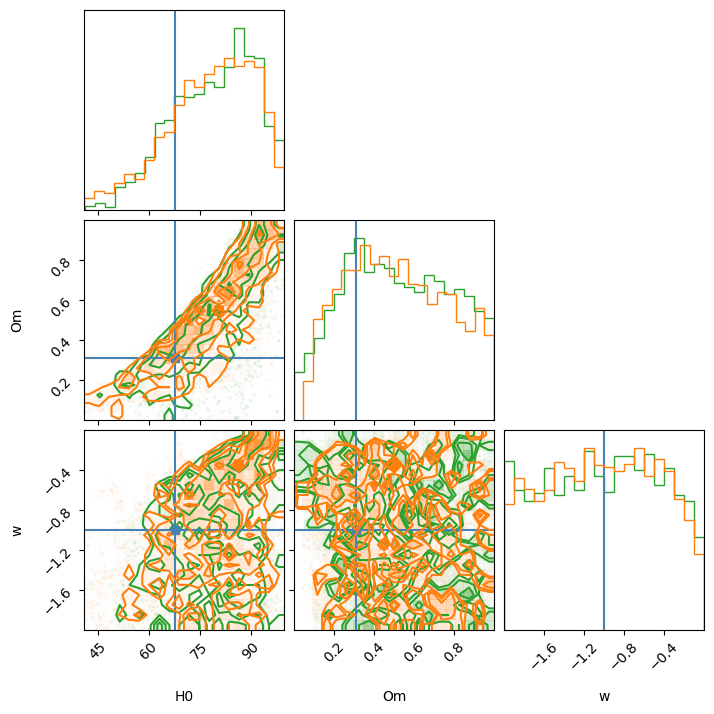

In [19]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[HUBBLE, OMEGA_MATTER, W_LAMBDA], color="C2"
)
corner.corner(
    flat_samples_PD, fig=fig, color="C1"
);

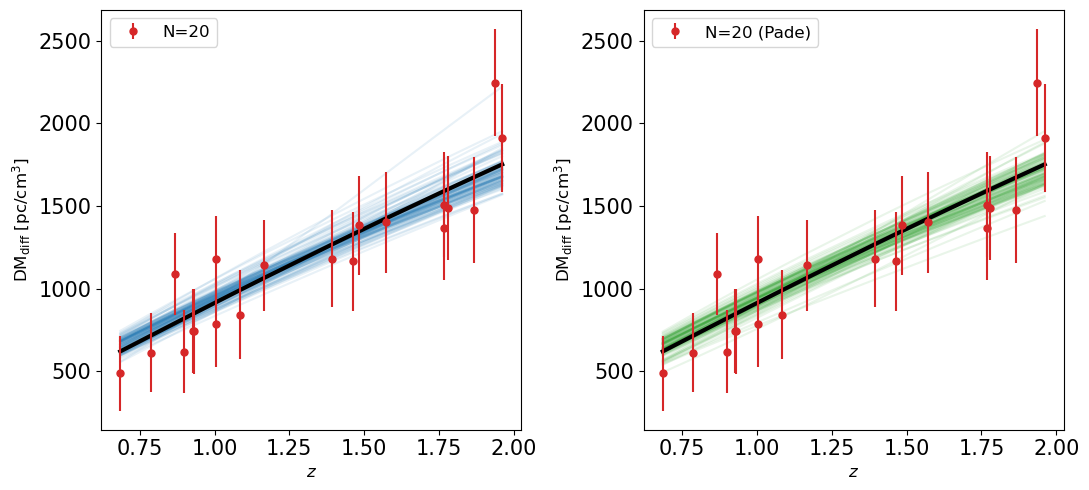

In [21]:
inds = rng.integers(len(flat_samples), size=100)

fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for ind in inds:
    sample = flat_samples[ind]
    DM_i = dispersion_measure(np.sort(z_centres), H0=sample[0], Om=sample[1], w=sample[2], alpha=f_ALPHA, f_IGM_0 = f_IGM)
    ax1.plot(np.sort(z_centres), DM_i, "tab:blue", alpha=0.1)
ax1.plot(np.sort(z_centres), np.sort(DM_centres), c='black', lw=3)
ax1.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=5, c='tab:red', label=f'N={N_EVENTS}')

ax1.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax1.set_xlabel(r'$z$', fontsize=12)
ax1.legend(loc='upper left', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=15)


for ind in inds:
    sample = flat_samples_PD[ind]
    DM_i = dispersion_measure(np.sort(z_centres), H0=sample[0], Om=sample[1], w=sample[2], alpha=f_ALPHA, f_IGM_0 = f_IGM)
    ax2.plot(np.sort(z_centres), DM_i, "tab:green", alpha=0.1)
ax2.plot(np.sort(z_centres), np.sort(DM_centres), c='black', lw=3)
ax2.errorbar(z_centres, DM_obs_centre, yerr=s_DM_obs, marker='o', ls='', ms=5, c='tab:red', label=f'N={N_EVENTS} (Pade)')

ax2.set_ylabel(r'${\rm DM}_{\rm diff}$ [pc/cm$^3$]', fontsize=12)
ax2.set_xlabel(r'$z$', fontsize=12)
ax2.legend(loc='upper left', fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()

-----------------------------------------------------------------------------